# Feature Engineering

In [11]:
import pandas as pd
import numpy as np
import os

# === Folders ===
raw_data_folder = r"C:\Users\haier\AI_Stock_Analyzer\Data\raw"
processed_folder = r"C:\Users\haier\AI_Stock_Analyzer\Data\processed"
os.makedirs(processed_folder, exist_ok=True)

# === Get all raw CSV files ===
raw_files = [f for f in os.listdir(raw_data_folder) if f.endswith(".csv")]
print(f"Found {len(raw_files)} raw data files:", raw_files)

all_data = []

for file in raw_files:
    ticker = file.replace(".csv", "")
    print(f"\nProcessing {ticker}...")

    # --- Load CSV ---
    df = pd.read_csv(os.path.join(raw_data_folder, file), parse_dates=["Date"])
    print(f"Initial shape for {ticker}: {df.shape}")

    if df.empty:
        print(f"Warning: No data for {ticker}, skipping.")
        continue

    # --- Ensure numeric columns are 1D floats ---
    for col in ["Close", "High", "Low", "Open", "Volume"]:
        df[col] = df[col].astype(float).squeeze()

    # --- Feature Engineering ---
    # Moving Averages
    df["MA10"] = df["Close"].rolling(window=10).mean()
    df["MA50"] = df["Close"].rolling(window=50).mean()
    df["MA200"] = df["Close"].rolling(window=200).mean()

    # Exponential Moving Averages
    df["EMA10"] = df["Close"].ewm(span=10, adjust=False).mean()
    df["EMA50"] = df["Close"].ewm(span=50, adjust=False).mean()

    # Returns & Volatility
    df["Return"] = df["Close"].pct_change()
    df["Volatility"] = df["Return"].rolling(window=20).std()

    # Momentum
    df["Momentum"] = df["Close"] - df["Close"].shift(10)

    # RSI
    delta = df["Close"].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=14).mean()
    avg_loss = pd.Series(loss).rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # MACD
    ema12 = df["Close"].ewm(span=12, adjust=False).mean()
    ema26 = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = ema12 - ema26
    df["MACD_signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

    # ATR
    high_low = df["High"] - df["Low"]
    high_close = np.abs(df["High"] - df["Close"].shift(1))
    low_close = np.abs(df["Low"] - df["Close"].shift(1))
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df["ATR"] = tr.rolling(window=14).mean()

    # Lag features
    df["Close_lag1"] = df["Close"].shift(1)
    df["Close_lag2"] = df["Close"].shift(2)
    df["Close_lag3"] = df["Close"].shift(3)

    print(f"Shape after feature creation: {df.shape}")
    print(f"NaN counts per column BEFORE dropna:\n{df.isna().sum()}\n")

    # Drop rows missing essential features
    df = df.dropna(subset=["MA10", "EMA10", "RSI", "MACD", "MACD_signal", "ATR", "Close_lag1"])

    print(f"Shape AFTER dropna: {df.shape}")
    if df.empty:
        print(f"⚠ All rows dropped for {ticker}. Check feature calculations above!\n")
        continue

    # Add Ticker column
    df["Ticker"] = ticker

    # Save processed CSV for this ticker
    processed_file_path = os.path.join(processed_folder, f"{ticker}_features.csv")
    df.to_csv(processed_file_path, index=False)
    print(f"Saved {len(df)} rows with features for {ticker}\n")

    all_data.append(df)

# Combine all processed tickers
if all_data:
    combined_df = pd.concat(all_data)
    combined_path = os.path.join(processed_folder, "all_stocks_features.csv")
    combined_df.to_csv(combined_path, index=False)
    print("\nFeature engineering complete.")
    print(f"Combined dataset saved to: {combined_path}")
    print(f"Final combined dataset shape: {combined_df.shape}")
    print(combined_df.head())
else:
    print("No data processed. Check printed NaN counts to find issues.")


Found 5 raw data files: ['AAPL.csv', 'AMZN.csv', 'MSFT.csv', 'NVDA.csv', 'TSLA.csv']

Processing AAPL...
Initial shape for AAPL: (2012, 6)
Shape after feature creation: (2012, 21)
NaN counts per column BEFORE dropna:
Date             0
Open             0
High             0
Low              0
Close            0
Volume           0
MA10             9
MA50            49
MA200          199
EMA10            0
EMA50            0
Return           1
Volatility      20
Momentum        10
RSI             13
MACD             0
MACD_signal      0
ATR             13
Close_lag1       1
Close_lag2       2
Close_lag3       3
dtype: int64

Shape AFTER dropna: (1999, 21)
Saved 1999 rows with features for AAPL


Processing AMZN...
Initial shape for AMZN: (2012, 6)
Shape after feature creation: (2012, 21)
NaN counts per column BEFORE dropna:
Date             0
Open             0
High             0
Low              0
Close            0
Volume           0
MA10             9
MA50            49
MA200          


Showing combined chart for AAPL...


C:\Users\haier\AppData\Local\Temp\ipykernel_4992\1763698837.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


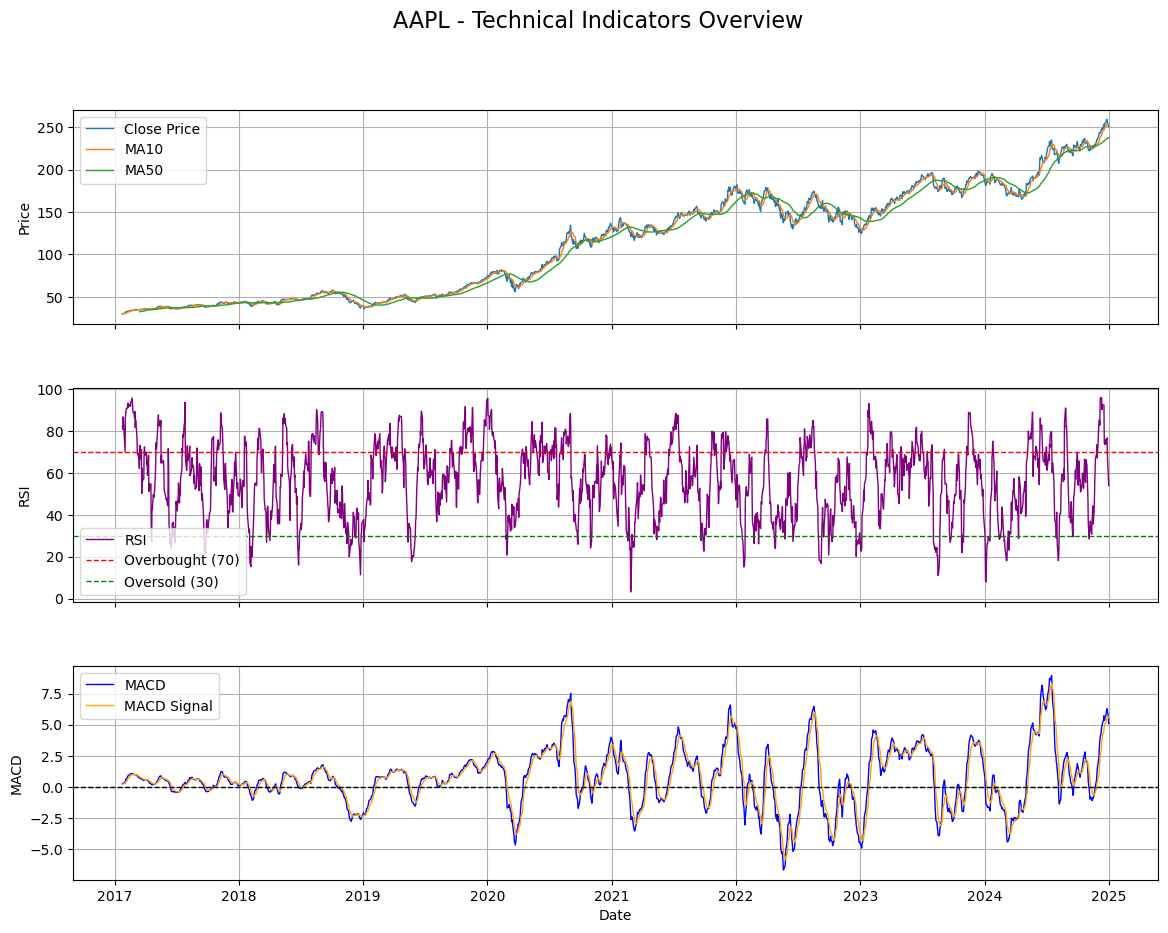


Showing combined chart for AMZN...


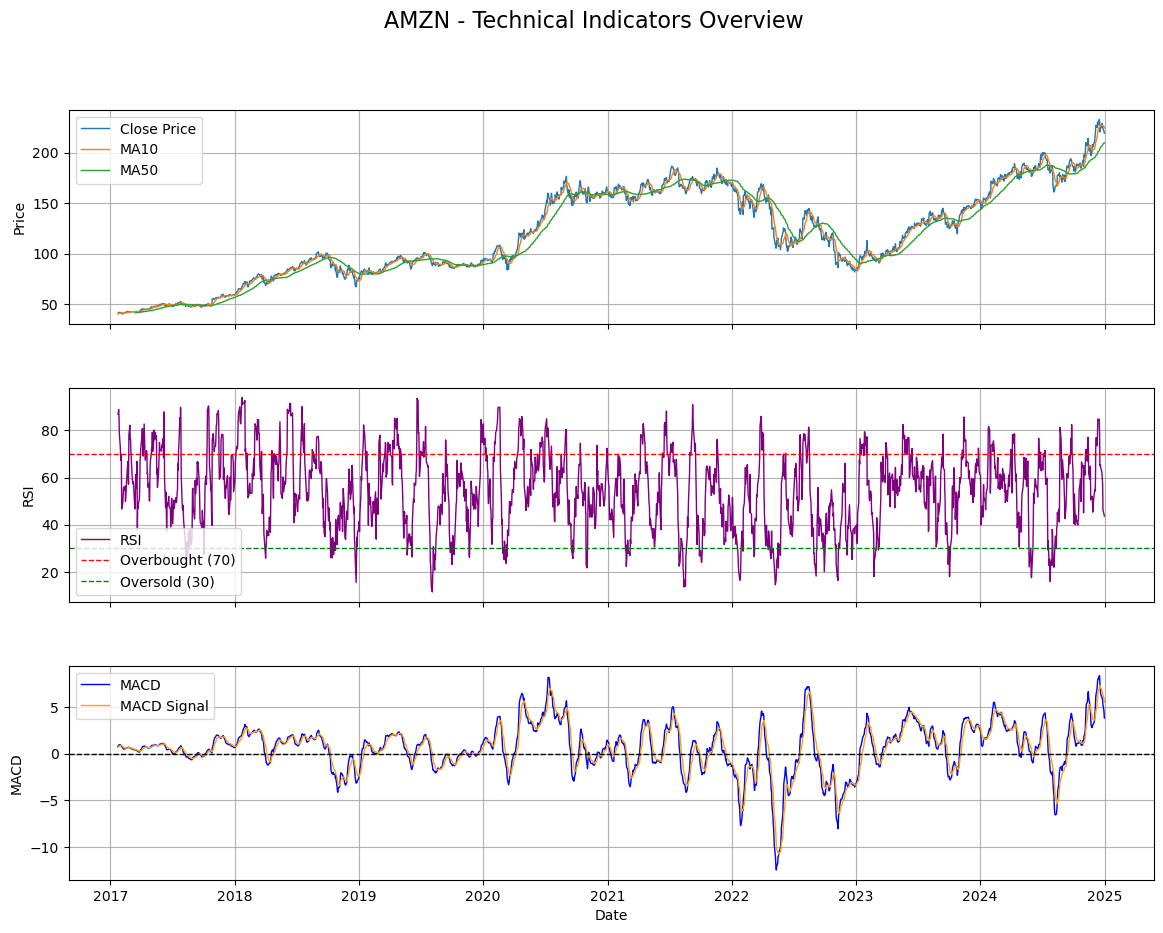


Showing combined chart for MSFT...


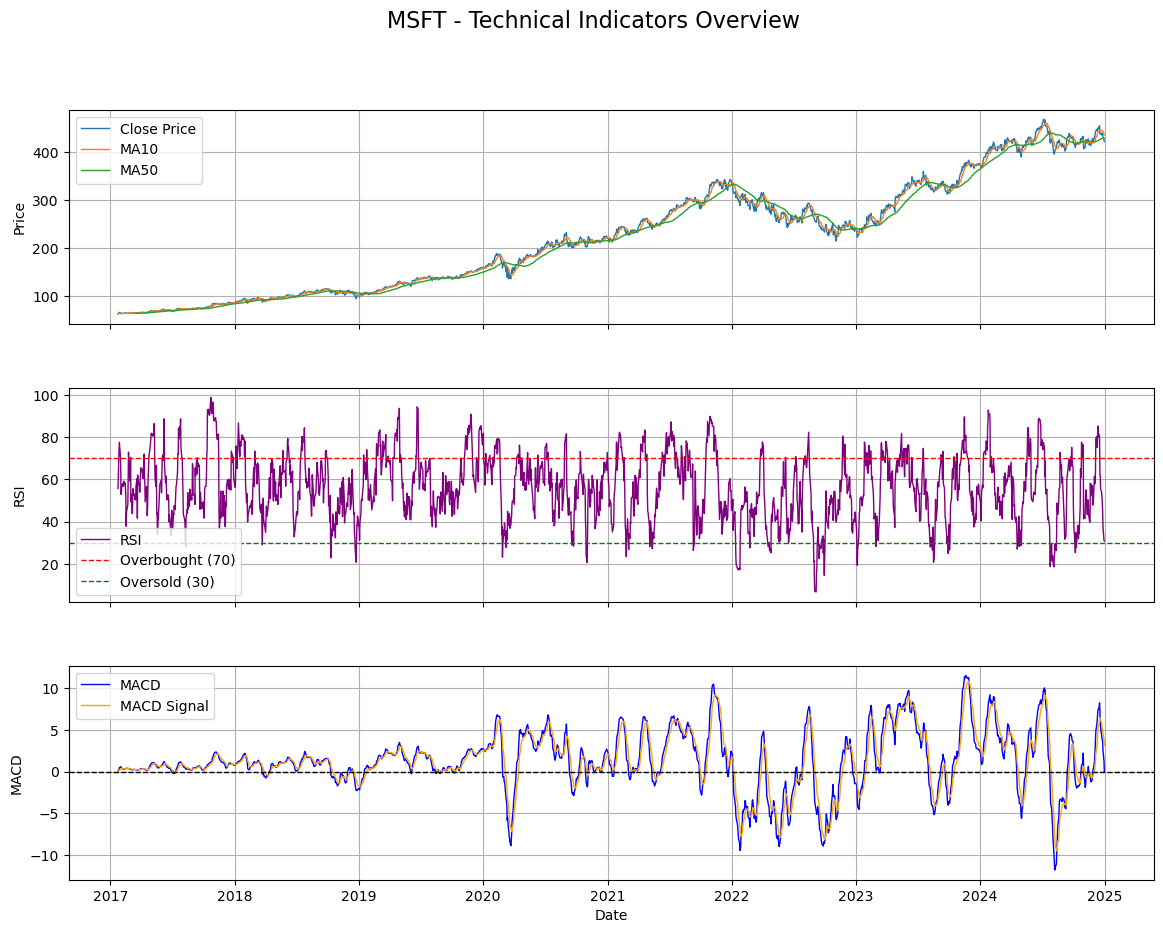


Showing combined chart for NVDA...


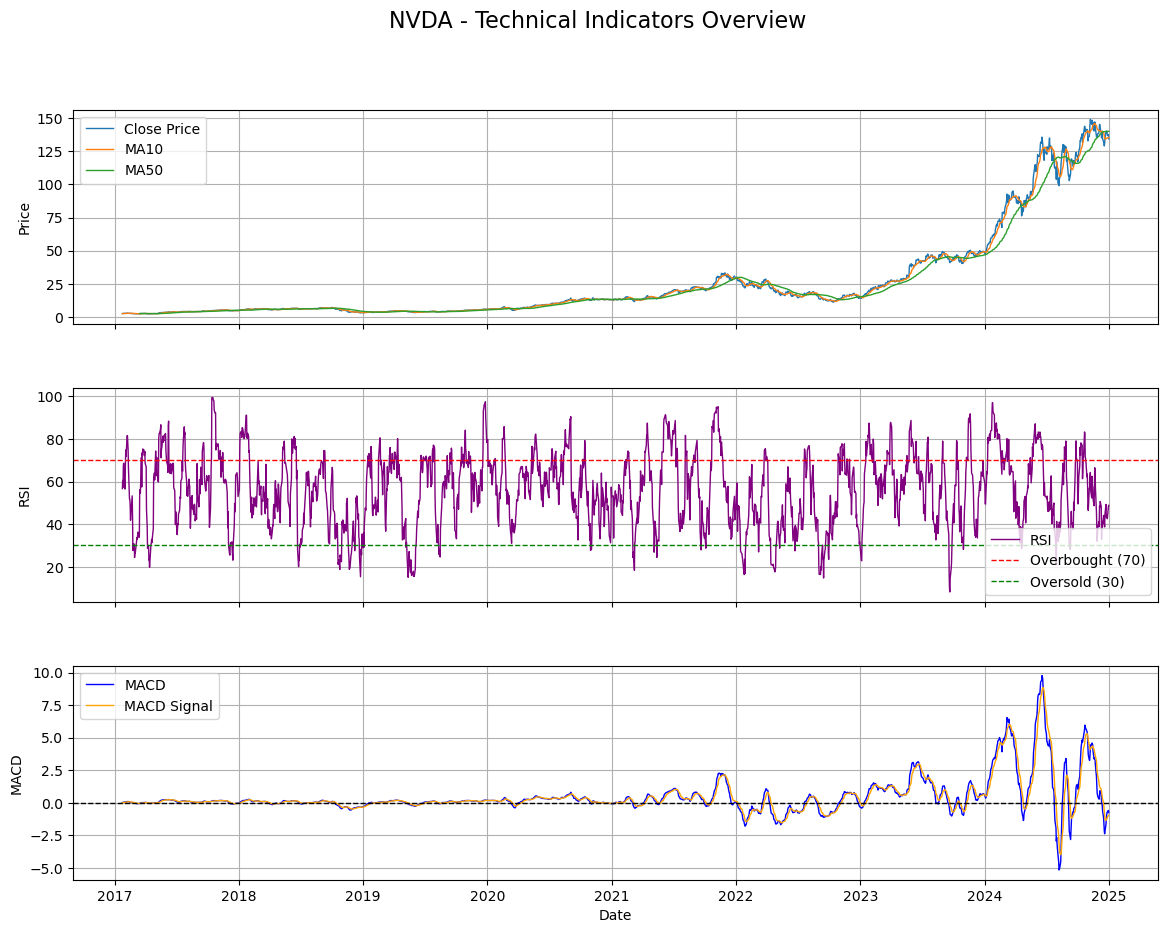


Showing combined chart for TSLA...


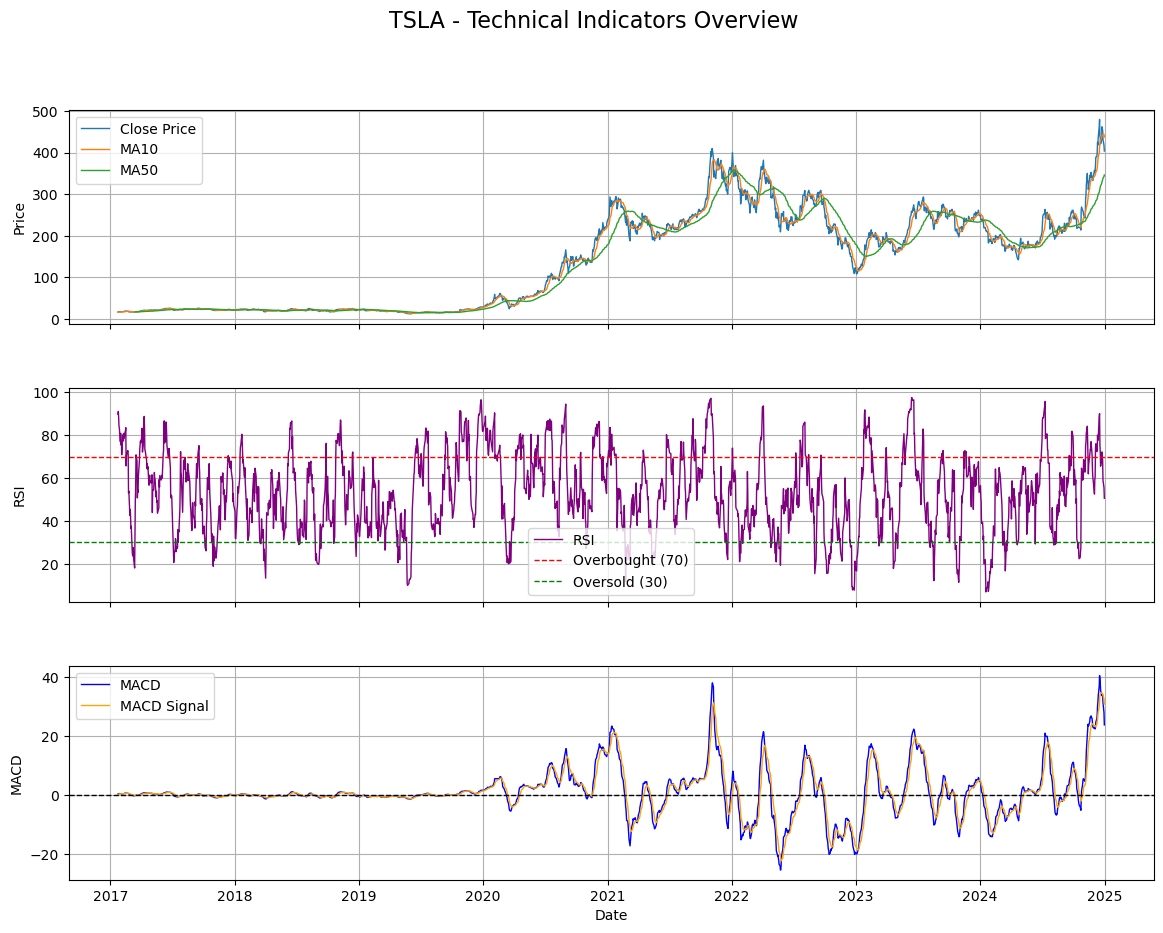

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load processed dataset
processed_file = r"C:\Users\haier\AI_Stock_Analyzer\Data\processed\all_stocks_features.csv"
df = pd.read_csv(processed_file, parse_dates=["Date"])

# Get unique tickers
tickers = df["Ticker"].unique()

for ticker in tickers:
    ticker_df = df[df["Ticker"] == ticker].copy()
    ticker_df.sort_values("Date", inplace=True)

    if ticker_df.empty:
        print(f"Skipping {ticker}, no data found.")
        continue

    print(f"\nShowing combined chart for {ticker}...")

    # Create figure with 3 stacked subplots (shared x-axis)
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True, gridspec_kw={'hspace': 0.3})
    fig.suptitle(f"{ticker} - Technical Indicators Overview", fontsize=16)

    # -------------------------------
    # 1) Close Price with MA10 & MA50
    # -------------------------------
    axes[0].plot(ticker_df["Date"], ticker_df["Close"], label="Close Price", linewidth=1)
    axes[0].plot(ticker_df["Date"], ticker_df["MA10"], label="MA10", linewidth=1)
    axes[0].plot(ticker_df["Date"], ticker_df["MA50"], label="MA50", linewidth=1)
    axes[0].set_ylabel("Price")
    axes[0].legend()
    axes[0].grid()

    # -------------------------------
    # 2) RSI
    # -------------------------------
    axes[1].plot(ticker_df["Date"], ticker_df["RSI"], label="RSI", color="purple", linewidth=1)
    axes[1].axhline(70, color="red", linestyle="--", linewidth=1, label="Overbought (70)")
    axes[1].axhline(30, color="green", linestyle="--", linewidth=1, label="Oversold (30)")
    axes[1].set_ylabel("RSI")
    axes[1].legend()
    axes[1].grid()

    # -------------------------------
    # 3) MACD & MACD Signal
    # -------------------------------
    axes[2].plot(ticker_df["Date"], ticker_df["MACD"], label="MACD", color="blue", linewidth=1)
    axes[2].plot(ticker_df["Date"], ticker_df["MACD_signal"], label="MACD Signal", color="orange", linewidth=1)
    axes[2].axhline(0, color="black", linestyle="--", linewidth=1)
    axes[2].set_ylabel("MACD")
    axes[2].set_xlabel("Date")
    axes[2].legend()
    axes[2].grid()

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


In [13]:
import pandas as pd
import numpy as np
import os

# === Folders ===
raw_data_folder = r"C:\Users\haier\AI_Stock_Analyzer\Data\raw"
processed_folder = r"C:\Users\haier\AI_Stock_Analyzer\Data\processed"
os.makedirs(processed_folder, exist_ok=True)

# === Get all raw CSV files ===
raw_files = [f for f in os.listdir(raw_data_folder) if f.endswith(".csv")]
print(f"Found {len(raw_files)} raw data files:", raw_files)

all_data = []

for file in raw_files:
    ticker = file.replace(".csv", "")
    print(f"\nProcessing {ticker}...")

    # --- Load CSV ---
    df = pd.read_csv(os.path.join(raw_data_folder, file), parse_dates=["Date"])
    print(f"Initial shape for {ticker}: {df.shape}")

    if df.empty:
        print(f"Warning: No data for {ticker}, skipping.")
        continue

    # --- Ensure numeric columns are floats ---
    for col in ["Close", "High", "Low", "Open", "Volume"]:
        df[col] = df[col].astype(float)

    # --- Feature Engineering ---
    # Moving Averages
    df["MA10"] = df["Close"].rolling(window=10).mean()
    df["MA50"] = df["Close"].rolling(window=50).mean()
    df["MA200"] = df["Close"].rolling(window=200).mean()

    # Exponential Moving Averages
    df["EMA10"] = df["Close"].ewm(span=10, adjust=False).mean()
    df["EMA50"] = df["Close"].ewm(span=50, adjust=False).mean()

    # Returns & Volatility
    df["Return"] = df["Close"].pct_change()
    df["Volatility"] = df["Return"].rolling(window=20).std()

    # Momentum
    df["Momentum"] = df["Close"] - df["Close"].shift(10)

    # RSI
    # Using a more robust, Pandas-native method
    delta = df["Close"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # MACD
    ema12 = df["Close"].ewm(span=12, adjust=False).mean()
    ema26 = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = ema12 - ema26
    df["MACD_signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

    # ATR
    high_low = df["High"] - df["Low"]
    high_close = np.abs(df["High"] - df["Close"].shift(1))
    low_close = np.abs(df["Low"] - df["Close"].shift(1))
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df["ATR"] = tr.rolling(window=14).mean()

    # Lag features
    df["Close_lag1"] = df["Close"].shift(1)
    df["Close_lag2"] = df["Close"].shift(2)
    df["Close_lag3"] = df["Close"].shift(3)

    print(f"Shape after feature creation: {df.shape}")
    print(f"NaN counts per column BEFORE dropna:\n{df.isna().sum()}\n")

    # Drop rows missing essential features
    df = df.dropna(subset=["MA10", "EMA10", "RSI", "MACD", "MACD_signal", "ATR", "Close_lag1"])

    print(f"Shape AFTER dropna: {df.shape}")
    if df.empty:
        print(f"⚠ All rows dropped for {ticker}. Check feature calculations above!\n")
        continue

    # Add Ticker column
    df["Ticker"] = ticker

    # Save processed CSV for this ticker
    processed_file_path = os.path.join(processed_folder, f"{ticker}_features.csv")
    df.to_csv(processed_file_path, index=False)
    print(f"Saved {len(df)} rows with features for {ticker}\n")

    all_data.append(df)

# Combine all processed tickers
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_path = os.path.join(processed_folder, "all_stocks_features.csv")
    combined_df.to_csv(combined_path, index=False)
    print("\nFeature engineering complete.")
    print(f"Combined dataset saved to: {combined_path}")
    print(f"Final combined dataset shape: {combined_df.shape}")
    print(combined_df.head())
else:
    print("No data processed. Check printed NaN counts to find issues.")

Found 5 raw data files: ['AAPL.csv', 'AMZN.csv', 'MSFT.csv', 'NVDA.csv', 'TSLA.csv']

Processing AAPL...
Initial shape for AAPL: (2012, 6)
Shape after feature creation: (2012, 21)
NaN counts per column BEFORE dropna:
Date             0
Open             0
High             0
Low              0
Close            0
Volume           0
MA10             9
MA50            49
MA200          199
EMA10            0
EMA50            0
Return           1
Volatility      20
Momentum        10
RSI             14
MACD             0
MACD_signal      0
ATR             13
Close_lag1       1
Close_lag2       2
Close_lag3       3
dtype: int64

Shape AFTER dropna: (1998, 21)
Saved 1998 rows with features for AAPL


Processing AMZN...
Initial shape for AMZN: (2012, 6)
Shape after feature creation: (2012, 21)
NaN counts per column BEFORE dropna:
Date             0
Open             0
High             0
Low              0
Close            0
Volume           0
MA10             9
MA50            49
MA200          